In [1]:
#pip install pygame

In [1]:
import numpy as np
import pygame
import matplotlib.pyplot as plt
import pandas as pd

pygame 2.0.1 (SDL 2.0.14, Python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
ROWS = 17
COLS = 15

In [3]:
racetrack_path='track3.csv'
racetrack_data = pd.read_csv(racetrack_path) 
track=racetrack_data.values

In [4]:
class Data:
    
    def get_start_line(self):
        '''
        Gets start line
        '''
        self.start_line = np.array([np.array([ROWS-1,j]) for j in range(COLS) if self.racetrack[ROWS-1,j] == 1])
        
    def get_finish_line(self):
        '''
        Gets finish line
        '''
        self.finish_line = np.array([np.array([0,i]) for i in range(COLS) if self.racetrack[0,i] == 2])
        
    def __init__(self):
        '''
            racetrack: 2 dimensional numpy array
            Q(s,a): 5 dimensional numpy array
            C(s,a): 5 dimensional numpy array
            pi: target policy
            start_line: start_line is the set of start states
            finish_line: finish_line is the set of finish states
            hyperparameters like epsilon
            episode to be an empty list
        '''
        self.ε = 0.1
        self.γ = 1
        self.episode = dict({'S':[],'A':[],'probs':[],'R':[None]})
        
        self.Q_vals = np.random.rand(ROWS,COLS,5,5,9)*400 - 500
        self.rewards = []
        self.C_vals = np.zeros((ROWS,COLS,5,5,9))
        self.pi = np.zeros((ROWS,COLS,5,5),dtype='int')
        self.racetrack = track
        
        self.get_start_line()
        self.get_finish_line()


In [5]:
class Environment:
    
    def get_new_state(self, state, action):
        '''
        Get new state after applying action on this state
        '''
        new_state = state.copy()
        new_state[0] = state[0] - state[2]
        new_state[1] = state[1] + state[3]
        new_state[2] = state[2] + action[0]
        new_state[3] = state[3] + action[1]
        return new_state
    
    def select_randomly(self,NUMPY_ARR):
        '''
        Returns a value uniform randomly from NUMPY_ARR
        Here NUMPY_ARR should be 1 dimensional
        '''
        return np.random.choice(NUMPY_ARR)
    
    def set_zero(NUMPY_ARR):
        '''
        Returns NUMPY_ARR after making zero all the elements in it
        '''
        NUMPY_ARR[:] = 0
        return NUMPY_ARR
    
    def is_finish_line_crossed(self, state, action):
        '''
        Returns True if the car crosses the finish line
                False otherwise
        '''
        new_state = self.get_new_state(state, action)
        old_cell, new_cell = state[0:2], new_state[0:2]
        
        '''
        new_cell's row index will be less
        '''
        rows = np.array(range(new_cell[0],old_cell[0]+1))
        cols = np.array(range(old_cell[1],new_cell[1]+1))
        fin = set([tuple(x) for x in self.data.finish_line])
        row_col_matrix = [(x,y) for x in rows for y in cols]
        intersect = [x for x in row_col_matrix if x in fin]
        
        return len(intersect) > 0
    
    def is_out_of_track(self, state, action):
        '''
        Returns True if the car goes out of track if action is taken on state
                False otherwise
        '''
        new_state = self.get_new_state(state, action)
        old_cell, new_cell = state[0:2], new_state[0:2]
        
        if new_cell[0] < 0 or new_cell[0] >= ROWS or new_cell[1] < 0 or new_cell[1] >= COLS:
            return True
        elif self.has_collided(new_cell,old_cell):
            return True
        else:
            return self.data.racetrack[tuple(new_cell)] == -1
    
    def __init__(self, data):
        '''
        initialize step_count to be 0
        '''
        self.data = data
        self.step_count = 0
    
    def reset(self):
        self.data.episode = dict({'S':[],'A':[],'probs':[],'R':[None]})
        self.step_count = 0
    
    def start(self):
        '''
        Makes the velocity of the car to be zero
        Returns the randomly selected start state.
        '''
        state = np.zeros(4,dtype='int')
        state[0] = ROWS-1
        state[1] = self.select_randomly(self.data.start_line[:,1])
        '''
        state[2] and state[3] are already zero
        '''
        return state
    
    def step(self, state, action):
        '''
        Returns the reward and new state when action is taken on state
        Checks the following 2 cases maintaining the order:
            1. car finishes race by crossing the finish line
            2. car hits obstacle
            3. car goes out of track
        Ends the episode by returning reward as None and state as usual (which will be terminating)
        '''
        self.data.episode['A'].append(action)
        reward = -1
        reward_obs = -10
        reward_finish = 10
        
        if (self.is_finish_line_crossed(state, action)):
            new_state = self.get_new_state(state, action)
            
            self.data.episode['R'].append(reward_finish)
            self.data.episode['S'].append(new_state)
            self.step_count += 1
            
            return None, new_state
            
        elif (self.is_out_of_track(state, action)):
            self.data.episode['R'].append(reward_obs)
            new_state = self.start()
        else:
            new_state = self.get_new_state(state, action)
        
        self.data.episode['R'].append(reward)
        self.data.episode['S'].append(new_state)
        self.step_count += 1
        
        return reward, new_state
    
    def has_collided(self, new_state,old_state):  
        #print("inside has_collided")
        sub_track=self.data.racetrack[min(old_state[0],new_state[0]):max(old_state[0],new_state[0])+1,min(old_state[1],new_state[1]):max(old_state[1],new_state[1])+1]
        if -1 in sub_track:
            return True
        else:
            return False

In [6]:
class Agent:
    
    def possible_actions(self, velocity):
        '''
        *** Performs two tasks, can be split up ***
        Universe of actions:  a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
                            
        Uses constraints to filter out invalid actions given the velocity
        
        0 <= v_x < 5
        0 <= v_y < 5
        v_x and v_y cannot be made both zero
        Returns list of possible actions given the velocity
        '''
        a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
        a = [np.array(x) for x in a]

        b = []
        for i,x in zip(range(9),a):
            new_vel = np.add(velocity,x)
            if (new_vel[0] < 5) and (new_vel[0] >= 0) and (new_vel[1] < 5) and (new_vel[1] >= 0) and ~(new_vel[0] == 0 and new_vel[1] == 0):
                b.append(i)
        b = np.array(b)
        
        return b
    
    def map_to_1D(self,action):
        a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
        for i,x in zip(range(9),a):
            if action[0]==x[0] and action[1]==x[1]:
                return i
    
    def map_to_2D(self,action):
        a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
        return a[action]
    
    def __init__(self):
        pass
    
    def get_action(self, state, policy):
        '''
        Returns action given state using policy
        '''
        return self.map_to_2D(policy(state, self.possible_actions(state[2:4])))

In [7]:
class Monte_Carlo_Control:
    
    def evaluate_target_policy(self):
        env.reset()
        state = env.start()
        self.data.episode['S'].append(state)
        rew = -1
        while rew!=None:
            action = agent.get_action(state,self.generate_target_policy_action)
            rew, state = env.step(state,action)
            
        self.data.rewards.append(sum(self.data.episode['R'][1:]))
        
    
    def plot_rewards(self):
        ax, fig = plt.subplots(figsize=(30,15))
        x = np.arange(1,len(self.data.rewards)+1)
        plt.plot(x*10, self.data.rewards, linewidth=3, color = '#0400FF')
        plt.xlabel('Episode number', size = 20)
        plt.ylabel('Reward',size = 20)
        plt.title('Plot of Reward vs Episode Number',size=20)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
    
    
    def determine_probability_behaviour(self, state, action, possible_actions):
        best_action = self.data.pi[tuple(state)]
        num_actions = len(possible_actions)
        
        if best_action in possible_actions:
            if action == best_action:
                prob = 1 - self.data.ε + self.data.ε/num_actions
            else:
                prob = self.data.ε/num_actions
        else:
            prob = 1/num_actions
        
        self.data.episode['probs'].append(prob)
    
    def generate_target_policy_action(self, state, possible_actions):
        '''
        Returns target policy action, takes state and
        returns an action using this policy
        '''
        if self.data.pi[tuple(state)] in possible_actions:
            action = self.data.pi[tuple(state)]
        else:
            action = np.random.choice(possible_actions)
            
        return action
    
    def generate_behavioural_policy_action(self, state, possible_actions):
        '''
        Returns behavioural policy action
        which would be ε-greedy pi policy, takes state and
        returns an action using this ε-greedy pi policy
        '''
        if np.random.rand() > self.data.ε and self.data.pi[tuple(state)] in possible_actions:
            action = self.data.pi[tuple(state)]
        else:
            action = np.random.choice(possible_actions)
        
        self.determine_probability_behaviour(state, action, possible_actions)
    
        return action
    
    def __init__(self, data):
        '''
        Initialize, for all s ∈ S, a ∈ A(s):
            data.Q(s, a) ← arbitrary (done in Data)
            data.C(s, a) ← 0 (done in Data)
            pi(s) ← argmax_a Q(s,a) 
            (with ties broken consistently) 
            (some consistent approach needs to be followed))
        '''
        self.data = data
        for i in range(ROWS):
            for j in range(COLS):
                if self.data.racetrack[i,j]!=-1:
                    for k in range(5):
                        for l in range(5):
                            self.data.pi[i,j,k,l] = np.argmax(self.data.Q_vals[i,j,k,l])
    
    def control(self,env,agent):
        '''
        Performs MC control using episode list [ S0 , A0 , R1, . . . , ST −1 , AT −1, RT , ST ]
        G ← 0
        W ← 1
        For t = T − 1, T − 2, . . . down to 0:
            G ← γ*G + R_t+1
            C(St, At ) ← C(St,At ) + W
            Q(St, At ) ← Q(St,At) + (W/C(St,At))*[G − Q(St,At )]
            pi(St) ← argmax_a Q(St,a) (with ties broken consistently)
            If At != pi(St) then exit For loop
            W ← W * (1/b(At|St))        
        '''
        env.reset()
        state = env.start()
        self.data.episode['S'].append(state)
        rew = -1
        while rew!=None:
            action = agent.get_action(state,self.generate_behavioural_policy_action)
            rew, state = env.step(state,action)
            #print(rew," ",action)
        
        G = 0
        W = 1
        T = env.step_count
        #print("T: ",T)
        for t in range(T-1,-1,-1):
            G = data.γ * G + self.data.episode['R'][t+1]
            S_t = tuple(self.data.episode['S'][t])
            A_t = agent.map_to_1D(self.data.episode['A'][t])
            
            S_list = list(S_t)
            S_list.append(A_t)
            SA = tuple(S_list)
            
            self.data.C_vals[SA] += W
            self.data.Q_vals[SA] += (W*(G-self.data.Q_vals[SA]))/(self.data.C_vals[SA])           
            self.data.pi[S_t] = np.argmax(self.data.Q_vals[S_t])
            if A_t!=self.data.pi[S_t]:
                break
            W /= self.data.episode['probs'][t]

In [8]:
class Visualizer:
    
    def visualize_episode():
        for i in range(self.data.episode['S']):
            vis.visualize_racetrack(i)
    
    def create_window(self):
        '''
        Creates window and assigns self.display variable
        '''
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Racetrack")
    
    def setup(self):
        '''
        Does things which occur only at the beginning
        '''
        self.cell_edge = 25
        self.width = COLS*self.cell_edge
        self.height = ROWS*self.cell_edge
        self.create_window()
        self.window = True

    def close_window(self):
        self.window = False
        pygame.quit()

    def draw(self, state = np.array([])):
        self.display.fill(0)
        for i in range(ROWS):
            for j in range(COLS):
                if self.data.racetrack[i,j]!=-1:
                    if self.data.racetrack[i,j] == 0:
                        color = (255,255,255)
                    elif self.data.racetrack[i,j] == 1:
                        color = (255,0,0)
                    elif self.data.racetrack[i,j] == 2:
                        color = (0,255,0)
                    pygame.draw.rect(self.display,color,((j*self.cell_edge,i*self.cell_edge),(self.cell_edge,self.cell_edge)),0)
                    pygame.draw.rect(self.display,(0, 0, 0),((j*self.cell_edge,i*self.cell_edge),(self.cell_edge,self.cell_edge)),1)
        
        if len(state)>0:
            pygame.draw.rect(self.display,(255,255,0),((state[1]*self.cell_edge,state[0]*self.cell_edge),(self.cell_edge,self.cell_edge)),0)
        
        pygame.display.update()
        
        global count
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.loop = False
                self.close_window()
                return 'stop'
            else:
                pygame.image.save(vis.display, str(count)+'.png')
                count += 1
                self.loop = False
                
        return None
        
    def visualize_racetrack(self, state = np.array([])):
        '''
        Draws Racetrack in a pygame window
        '''
        if self.window == False:
            self.setup()
        self.loop = True
        while(self.loop):
            ret = self.draw(state)
            if ret!=None:
                return ret
    
    def __init__(self,data):
        self.data = data
        self.window = False

In [9]:
data = Data()
env = Environment(data)
mcc = Monte_Carlo_Control(data)
vis = Visualizer(data)
agent = Agent()

In [10]:
 #vis.visualize_racetrack()

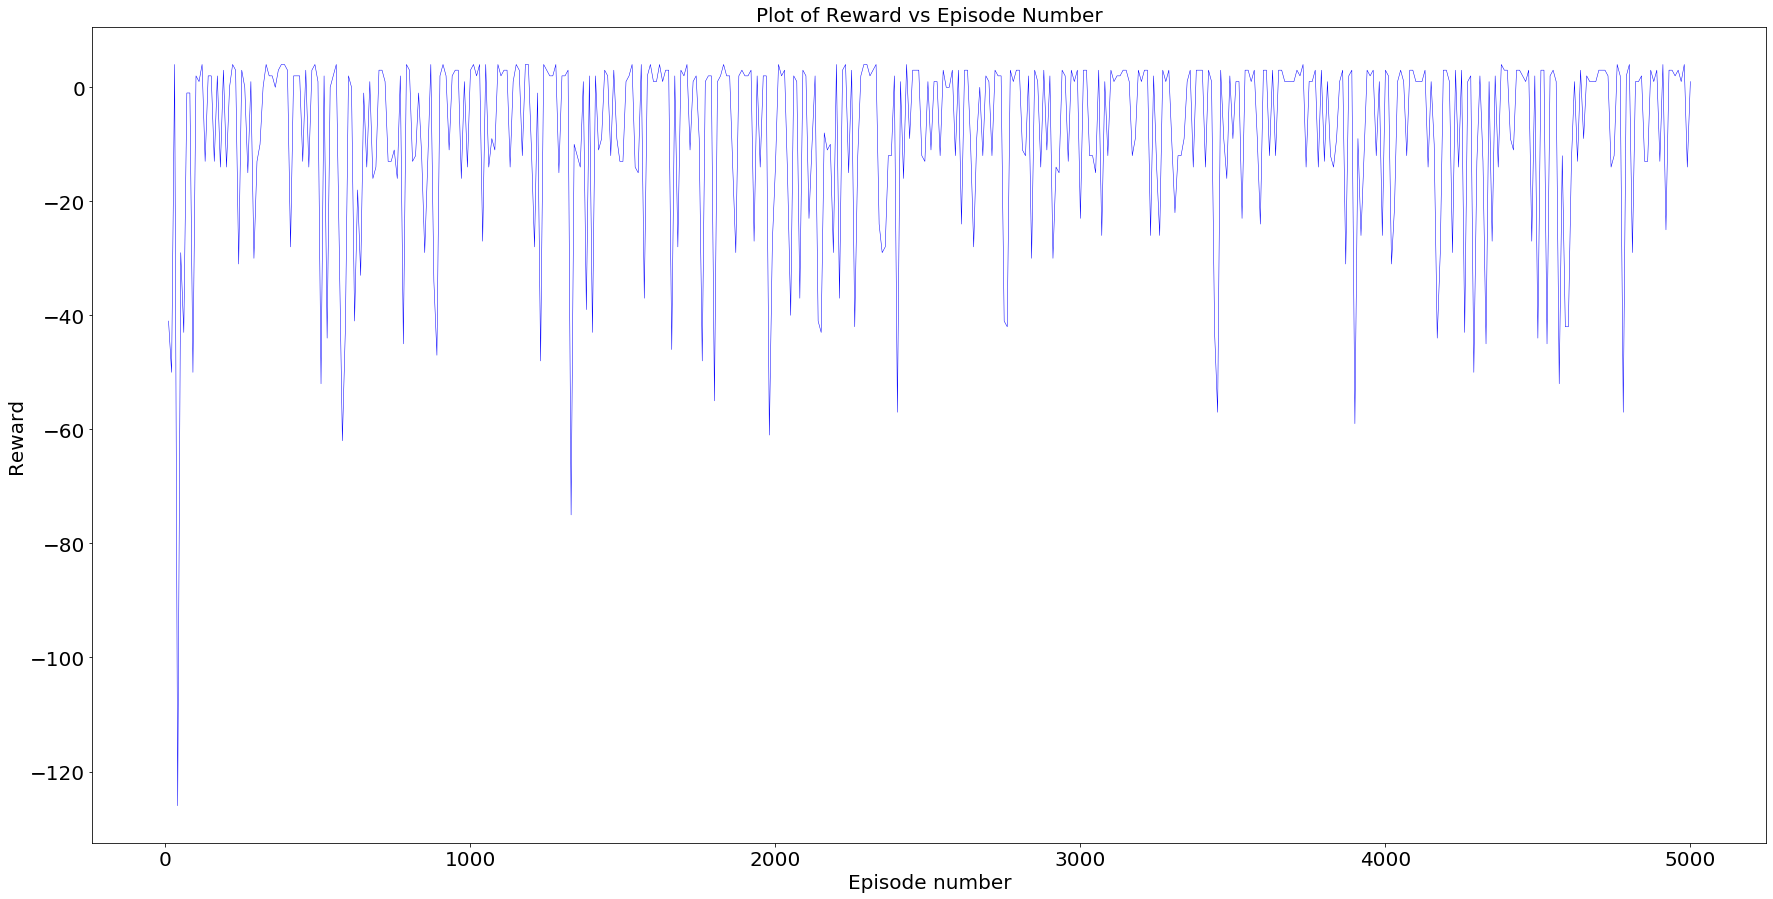

In [11]:
for i in range(5000):
    mcc.control(env,agent)
    if i%10 == 9:
        mcc.evaluate_target_policy()
    
mcc.plot_rewards()

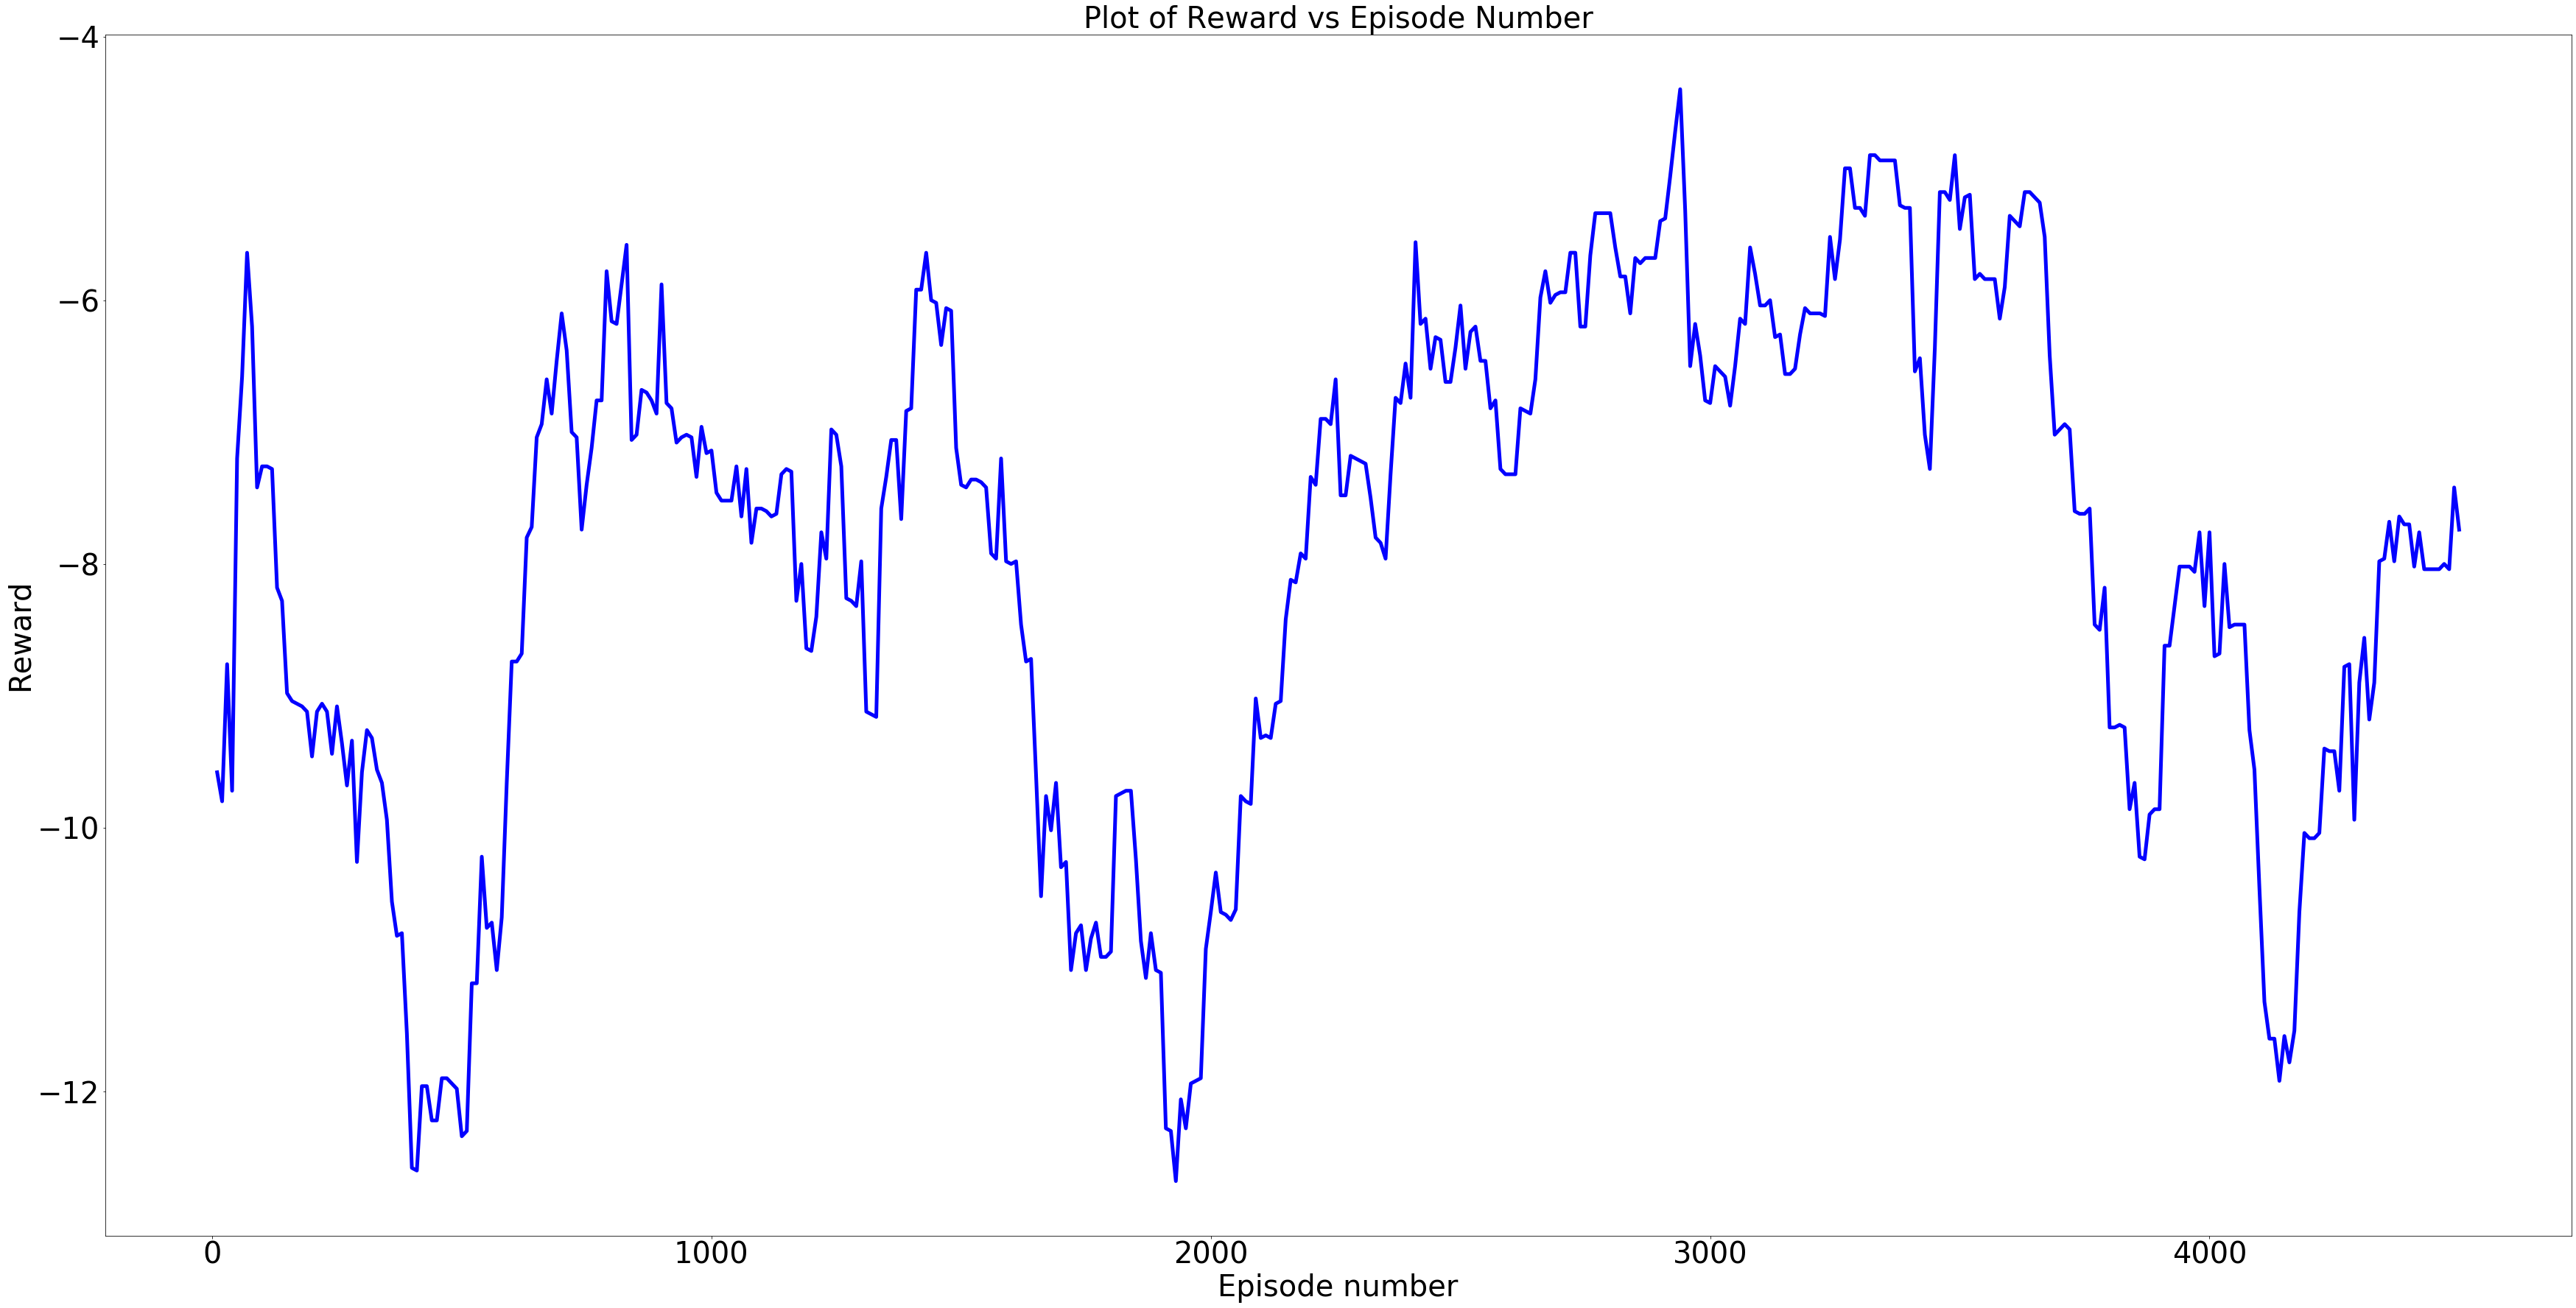

In [18]:
ch = 50
S = sum(data.rewards[:ch])/ch

R = []

for i in range(ch,len(data.rewards)):
    R.append(S)
    S *= ch
    S += data.rewards[i]
    S -= data.rewards[i-ch]
    S /= ch

ax, fig = plt.subplots(figsize=(60,30))
x = np.arange(1,len(R)+1)
plt.plot(x*10, R, linewidth=5, color = '#0400FF')
plt.xlabel('Episode number', size = 40)
plt.ylabel('Reward',size = 40)
plt.title('Plot of Reward vs Episode Number',size=40)
plt.xticks(size=40)
plt.yticks(size=40)
plt.show()

In [13]:
count = 0
env.reset()
state = env.start()
mcc.data.episode['S'].append(state)
rew = -1
while rew!=None:
    action = agent.get_action(state,mcc.generate_target_policy_action)
    rew, state = env.step(state,action)

In [14]:
from os import listdir
def list_files(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))
    '''
    returns List of all files with given extension project folder
    ''' 

In [15]:
import time
import os

filenames = []

directory = "C:/Users/ashra/OneDrive/Desktop/ObstacleRace/"
files = list_files(directory, "png")

for item in files:
    if item.endswith(".png"):
        os.remove(os.path.join(directory, item))
        '''
        Delete all previous png present in project folder
        '''        
        
print("press any key over game display")
for i in data.episode['S']:    
    if vis.visualize_racetrack(i) == 'stop':
        break
vis.close_window()

press any key over game display


In [16]:
import imageio
from os import listdir
from IPython.display import Image

def list_files(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))

filenames = []

directory = "C:/Users/ashra/OneDrive/Desktop/ObstacleRace/"
files = list_files(directory, "png")

for f in files:
    filenames.append(f)

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images, duration = 0.25)

Image(url='movie.gif')  